# Making and Evaluating patient embeddings

What will we do:
- collect and observe patients data
- use an LLM model to embed the medical information into a vector
- evaluate the predictive power of the embeddings
- filter the most predictive ones

In [1]:
import pandas as pd
import umap
from sklearn.metrics import classification_report
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import shap
import torch
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from transformers import AutoTokenizer, AutoModel
from LabData.DataLoaders.SubjectLoader import SubjectLoader
from LabData.DataLoaders.GutMBLoader import GutMBLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.UltrasoundLoader import UltrasoundLoader
from LabData.DataLoaders.ABILoader import ABILoader
from LabData.DataLoaders.ItamarSleepLoader import ItamarSleepLoader
from LabData.DataLoaders.MedicalConditionLoader import MedicalConditionLoader
from LabData.DataLoaders.MedicalProceduresLoader import MedicalProceduresLoader
from LabData.DataLoaders.Medications10KLoader import Medications10KLoader
from LabData.DataLoaders.LifeStyleLoader import LifeStyleLoader
from LabData.DataLoaders.DemographicsLoader import DemographicsLoader
from LabData.DataLoaders.ECGTextLoader import ECGTextLoader
from LabData.DataLoaders.DEXALoader import DEXALoader
from LabData.DataLoaders.PRSLoader import PRSLoader
from LabData.DataLoaders.HormonalStatusLoader import HormonalStatusLoader
from LabData.DataLoaders.IBSTenkLoader import IBSTenkLoader
from LabData.DataLoaders.SerumMetabolomicsLoader import SerumMetabolomicsLoader
from LabData.DataLoaders.FamilyMedicalConditionsLoader import FamilyMedicalConditionsLoader
from LabData.DataLoaders.ChildrenLoader import ChildrenLoader
from LabData.DataLoaders.MentalLoader import MentalLoader
from LabData.DataLoaders.TimelineLoader import TimelineLoader
from LabData.DataLoaders.SubjectRelationsLoader import SubjectRelationsLoader
from LabData.DataLoaders.RetinaScanLoader import RetinaScanLoader
from LabData.DataLoaders.PAStepsLoader import PAStepsLoader
import warnings

# Suppress all warnings globally
warnings.filterwarnings('ignore')

/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
study_ids = [10, 1001, 1002]
SubjectLoader().get_data(study_ids=study_ids).df.head(3)

,,StudyTypeID,city,country,gender,month_of_birth,us_state,yob,StudyTypeID2,StudyTypeID3,StudyTypeID4,StudyTypeID5,StudyTypeID6,StudyTypeID7,StudyTypeID8,StudyTypeID9,age,tz
RegistrationCode,Date,,,,,,,,,,,,,,,,,
10K_1000028368,2020-03-22 08:26:05.077073,10.0,None,IL,1.0,9,None,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,Asia/Jerusalem
10K_1000273395,2020-03-05 20:53:54.399388,10.0,None,IL,1.0,3,None,1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,Asia/Jerusalem
10K_1000633050,2021-06-21 14:23:50.372010,10.0,None,IL,0.0,7,None,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,Asia/Jerusalem


In [4]:
bm = BodyMeasuresLoader().get_data(study_ids=study_ids).df.join(BodyMeasuresLoader().get_data(study_ids=study_ids).df_metadata)

general_info = bm.reset_index().set_index('RegistrationCode')
general_info = general_info[~general_info['gender'].isna()]
general_info = general_info[~general_info['age'].isna()]

gender_dictionary = {1:'male', 0:'female'}

general_info.loc[:,'gender'] = general_info['gender'].fillna(0).map(gender_dictionary)

general_info.head(10)

/tmp/ipykernel_108610/1518352966.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['male' 'female' 'female' ... 'male' 'male' 'female']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  general_info.loc[:,'gender'] = general_info['gender'].fillna(0).map(gender_dictionary)


,Date,bmi,body_temperature,hand_grip_right,body_fat,fingers_grip_left,fingers_grip_right,frequency_of_period,sitting_blood_pressure_pulse_rate,on_hormone_therapy,...,sitting_second_blood_pressure_diastolic,sitting_another_hand_blood_pressure_systolic,age,country,month_of_birth,sitting_second_blood_pressure_systolic,sitting_another_hand_blood_pressure_diastolic,StudyTypeID8,gender,StudyTypeID3
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,2021-12-13 07:09:38.954985,28.176579,NaN,128.500000,NaN,NaN,NaN,NaN,55.0,NaN,...,NaN,NaN,54.0,IL,8.0,NaN,NaN,NaN,male,NaN
10K_1001201093,2021-08-26 07:39:21.411519,20.553633,NaN,65.000000,NaN,NaN,NaN,NaN,66.0,NaN,...,NaN,NaN,42.0,IL,8.0,NaN,NaN,NaN,female,NaN
10K_1001201093,2023-09-12 10:23:05.534125,20.833334,NaN,64.000000,NaN,NaN,NaN,NaN,74.0,NaN,...,57.0,108.0,44.0,IL,8.0,107.0,56.0,NaN,female,NaN
10K_1002033709,2022-08-03 07:20:01.044769,21.755468,NaN,56.000000,NaN,NaN,NaN,NaN,70.0,NaN,...,74.0,NaN,43.0,IL,10.0,100.0,NaN,NaN,female,NaN
10K_1002087123,2019-12-04 11:53:40.350115,36.660603,36.9,62.200001,45.099998,NaN,NaN,NaN,77.0,NaN,...,NaN,NaN,42.0,IL,11.0,NaN,NaN,NaN,female,NaN
10K_1002087123,2022-03-22 11:42:27.565348,34.487587,NaN,65.199997,NaN,NaN,NaN,NaN,72.0,NaN,...,NaN,NaN,45.0,IL,11.0,NaN,NaN,NaN,female,NaN
10K_1002254441,2022-09-15 07:00:31.408388,23.355637,NaN,86.099998,NaN,NaN,NaN,NaN,73.0,NaN,...,72.0,NaN,45.0,IL,11.0,103.0,NaN,NaN,male,NaN
10K_1002254441,2025-02-13 06:20:52.699166,24.545948,NaN,93.599998,NaN,NaN,NaN,NaN,65.0,NaN,...,74.0,130.0,48.0,IL,11.0,121.0,75.0,NaN,male,NaN
10K_1003113258,2020-02-09 12:38:07.180299,23.860134,36.6,106.800003,36.599998,NaN,NaN,NaN,51.0,NaN,...,NaN,NaN,49.0,IL,1.0,NaN,NaN,NaN,male,NaN


In [5]:
general_info = general_info.reset_index()
# Count the number of unique RegistrationCodes
unique_count = general_info['RegistrationCode'].nunique()

# Calculate the frequency for each unique RegistrationCode
frequency_series = general_info['RegistrationCode'].value_counts()

# Compute the average and median frequencies
average_frequency = frequency_series.mean()
median_frequency = frequency_series.median()

print("Unique RegistrationCodes:", unique_count)
print("Average frequency per RegistrationCode:", average_frequency)
print("Median frequency per RegistrationCode:", median_frequency)


Unique RegistrationCodes: 12226
Average frequency per RegistrationCode: 1.7416162277114347
Median frequency per RegistrationCode: 2.0


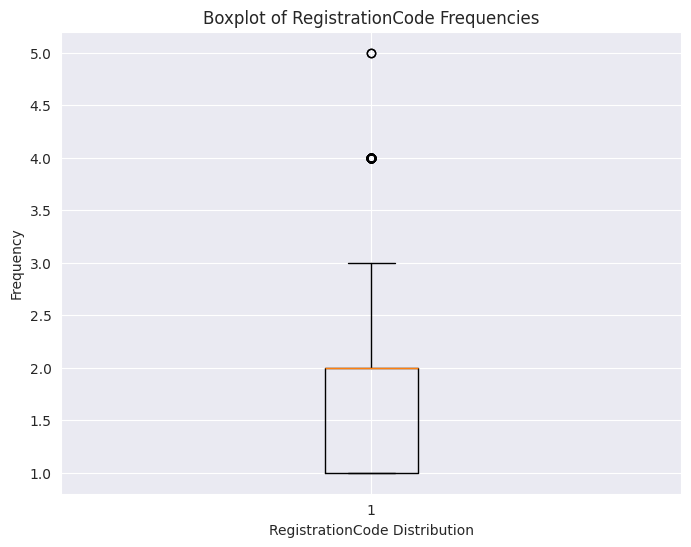

In [6]:
plt.figure(figsize=(8, 6))
plt.boxplot(frequency_series, vert=True)
plt.xlabel('RegistrationCode Distribution')
plt.ylabel('Frequency')
plt.title('Boxplot of RegistrationCode Frequencies')
plt.show()

In [7]:
# Count how many RegistrationCodes have frequencies of 1 through 5
frequency_counts = frequency_series.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

# Display the results
for freq, count in frequency_counts.items():
    print(f"Number of RegistrationCodes with frequency {freq}: {count}")

Number of RegistrationCodes with frequency 1: 5298
Number of RegistrationCodes with frequency 2: 4873
Number of RegistrationCodes with frequency 3: 1973
Number of RegistrationCodes with frequency 4: 80
Number of RegistrationCodes with frequency 5: 2


### get the basleine and follow up conditions

In [8]:
path_file = '/net/mraid20/export/genie/LabData/Data/10K/for_review/'
file_name = 'follow_up_conditions_all.csv'
file_name_1 = 'baseline_conditions_all.csv'
full_path = path_file + file_name
full_path_1 = path_file + file_name_1

# Read the CSV file into a DataFrame
df_conditions_follow_up = pd.read_csv(full_path)
df_conditions_baseline = pd.read_csv(full_path_1)

# Display the first few rows of the DataFrame
df_conditions_baseline.head()

,RegistrationCode,medical_condition,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,index,Baseline_Date
0,10K_1000942861,BlockL2-6A7,2008-01-01,True,דיכאון,2021-06-11 11:51:55,baseline,Neurologic,Depression,Depressive disorders,NaN,NaN
1,10K_1000942861,DB60,2000-01-01,True,טחורים,2021-06-11 11:51:55,baseline,Surgery,Haemorrhoids,Haemorrhoids,NaN,NaN
2,10K_1000942861,RA01,2020-12-23,True,קורונה,2023-12-25 12:52:12.534390+00:00,baseline,Infectious Disease,COVID-19,COVID-19,NaN,NaN
3,10K_1002033709,ED80,2000-01-01,True,אקנה,2022-01-11 07:16:11.594000,baseline,Dermatology,Allergy,Acne,NaN,NaN
4,10K_1002033709,GC08.Z,2000-01-01,True,דלקת בשתן,2022-01-11 07:16:11.594000,baseline,Urology,Urinary tract infection,"Urinary tract infection, site and agent not sp...",NaN,NaN


In [42]:
df_conditions_follow_up.head()

,RegistrationCode,medical_condition,index,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,Baseline_Date
0,10K_1001201093,RA01,560,2022-05-01 00:00:00.000000,True,קורונה,2022-08-02 05:48:59.526988+00:00,01_00_call,Infectious Disease,COVID-19,COVID-19,2021-08-26 07:39:21.411519
1,10K_1002087123,DA63,562,2021-01-01 00:00:00.000000,True,כיב בתריסריון (DA63),2022-03-22 12:42:01.880301+00:00,02_00_visit,Gastro,Peptic Ulcer Disease,Duodenal ulcer,2019-12-04 11:53:40.350115
2,10K_1002087123,GB70,561,2021-01-01 00:00:00.000000,True,אבנים בכליות (GB70),2022-03-22 12:42:01.880301+00:00,02_00_visit,Urology,Renal stones,Calculus of upper urinary tract,2019-12-04 11:53:40.350115
3,10K_1002087123,RA01,563,2022-12-06 00:00:00.000000,True,קורונה,2023-01-23 08:41:22.433394+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2019-12-04 11:53:40.350115
4,10K_1007330152,RA01,564,2023-01-01 00:00:00.000000,True,קורונה,2023-11-12 06:33:59.308045+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2020-11-16 12:25:48.195845


### which conditions can we find in the baseline and follow up?

In [43]:
df_conditions_baseline['english_name'].value_counts()

english_name
Hyperlipoproteinaemia                       2535
Haemorrhoids                                2432
Spinal pain                                 2331
Attention deficit hyperactivity disorder    2196
Allergic rhinitis                           1391
                                            ... 
Acute pericarditis                             1
Fracture of shoulder or upper arm              1
Non-alcoholic steatohepatitis                  1
Horner syndrome                                1
Tourette syndrome                              1
Name: count, Length: 427, dtype: int64

In [44]:
df_conditions_follow_up['english_name'].value_counts()

english_name
COVID-19                                                                                   6157
Hyperlipoproteinaemia                                                                       382
Essential hypertension                                                                      219
Intermediate hyperglycaemia                                                                 196
Other specified conditions associated with the spine (intervertebral disc displacement)      91
                                                                                           ... 
Perforation of tympanic membrane                                                              1
Essential tremor or related tremors                                                           1
Spondylolisthesis                                                                             1
Pericardial effusion                                                                          1
Allergic rhinitis          

### the different stages of follow up

In [45]:
df_conditions_follow_up['research_stage'].value_counts()

research_stage
01_00_call     3901
02_00_visit    2233
03_00_call     2109
04_00_visit     384
05_00_call      203
04_01_call       48
02_01_call       42
01_01_visit       5
06_00_visit       3
01_01_call        2
00_01_visit       1
03_01_visit       1
Name: count, dtype: int64

### merge DataFrames on 'RegistrationCode' and 'english_name' to find common records

In [46]:

common_conditions = pd.merge(df_conditions_baseline, df_conditions_follow_up, on=['RegistrationCode', 'english_name'], how='inner')['RegistrationCode'].nunique()


# Display the result
print(f"Number of patients with the same disease in both DataFrames: {common_conditions}")

Number of patients with the same disease in both DataFrames: 5


In [47]:
# Get the unique patient IDs from df_condition_baseline:
unique_patients = df_conditions_baseline["RegistrationCode"].unique()

## Building the embeddings

### ----- Step 1: Load Clinical BERT Model -----


In [48]:
# Load Clinical BERT (Bio_ClinicalBERT) tokenizer and model from Hugging Face:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Set model to evaluation mode (no gradients needed)
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

###  ----- Step 2: Create a Node for Each Patient with an Embedding -----

In [49]:
patient_embeddings = {}

# Ensure we only keep the earliest date entry for each patient
general_info_sorted = general_info.sort_values(by="Date")
general_info_unique = general_info_sorted.groupby("RegistrationCode").first().reset_index()

for patient in unique_patients:
    # Get all condition names for the patient from df_conditions_baseline
    conditions = df_conditions_baseline.loc[
        df_conditions_baseline["RegistrationCode"] == patient, "english_name"
    ]
    combined_conditions = "; ".join(conditions.astype(str).unique())

    # Get the patient's clinical information from general_info_unique (only earliest entry)
    patient_info_rows = general_info_unique.loc[general_info_unique["RegistrationCode"] == patient]

    if not patient_info_rows.empty:
        row = patient_info_rows.drop(columns=[
            "RegistrationCode", 'StudyTypeID9', 'StudyTypeID5',
                                              'StudyTypeID8', 'source_created_at', 'us_state',
                                              'city','StudyTypeID3','StudyTypeID7',
                                              'StudyTypeID2','StudyTypeID', "tz", "Date"
        ]).iloc[0]

        info_parts = [f"{col}: {val}" for col, val in row.items() if pd.notna(val)]
        patient_info_text = ", ".join(info_parts)
    else:
        patient_info_text = ""

    # Construct the text prompt for Clinical BERT with enriched explanations
    text_prompt = (f"Patient Medical Summary:\n\n"
                   f"1) Diagnosed Conditions:\n - {combined_conditions}\n\n"
                   f"2) Medical History & General Information:\n"
                   f"  - {patient_info_text}\n\n"
                   f"Definitions for key medical terms:\n"
                   f"- BMI (Body Mass Index) is a measure of body fat based on height and weight.\n"
                   f"- WHR (Waist-to-Hip Ratio) is an indicator of cardiovascular risk.\n"
                   f"- BMR (Basal Metabolic Rate) represents the number of calories the body burns at rest.\n"
                   f"- Systolic Blood Pressure (SBP) is the pressure when the heart beats.\n"
                   f"- Diastolic Blood Pressure (DBP) is the pressure when the heart is at rest.\n"
                   f"- Grip Strength is a measure of overall muscle strength.\n"
                   f"- Trunk Fat and Body Fat percentages indicate fat distribution and overall adiposity.\n\n"
                   f"Task: Classify whether this patient is healthy or at risk of one of these six target conditions: "
                   f"Essential hypertension, Osteoporosis, Diabetes mellitus (type unspecified), Coronary atherosclerosis, "
                   f"Malignant neoplasms of the breast, Hyperplasia of the prostate.")

    # Tokenize and generate embeddings
    inputs = tokenizer(text_prompt, return_tensors="pt", truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    # Use the [CLS] token's embedding
    embedding = outputs.last_hidden_state[:, 0, :]
    patient_embeddings[patient] = embedding.squeeze(0)

# Stack all patient embeddings into a tensor
all_embeddings = torch.stack([patient_embeddings[pid] for pid in unique_patients], dim=0)

print("Generated embeddings for each patient node:")
print(all_embeddings.shape)

Generated embeddings for each patient node:
torch.Size([11408, 768])


### ----- Step 3: Save the embeddings for easy retrieval -----

In [50]:
# Option A: Save as a PyTorch file
torch.save({'RegistrationCodes': unique_patients, 'embeddings': all_embeddings}, 'patient_embeddings.pt')

# Option B: Convert to a DataFrame and save as CSV
embedding_dim = all_embeddings.shape[1]
embeddings_list = [patient_embeddings[pid].tolist() for pid in unique_patients]

embedding_df = pd.DataFrame(embeddings_list, columns=[f'emb_{i}' for i in range(embedding_dim)])
embedding_df.insert(0, 'RegistrationCode', unique_patients)
embedding_df.to_csv("patient_embeddings.csv", index=False)

print("Embeddings saved successfully!")

Embeddings saved successfully!


### -----Step 4: repeat for the follow up infomration -----

In [51]:
# A patient that is being diagnosed with one of the following conditions must be excluded after the diagnostic visit
excluded_conditions = [
    "Essential hypertension",
    "Osteoporosis",
    "Diabetes mellitus, type unspecified",
    "Coronary atherosclerosis",
    "Malignant neoplasms of breast",
    "Hyperplasia of prostate"
]

# ----- Helper: Stage Parsing for Ordering & Comparison -----
def stage_to_tuple(stage):
    """
    Convert a research stage string (e.g., "01_00_call", "01_01_visit") to a tuple
    for ordering and comparison.
    """
    parts = stage.split('_')
    # parts[0] = years (nn), parts[1] = event number (xx), parts[2] = type ("call"/"visit")
    return (int(parts[0]), int(parts[1]), parts[2])

# ----- Assume DataFrames Are Loaded -----
# df_conditions_follow_up: contains at least the columns "RegistrationCode", "english_name", and "research_stage".
# general_info: contains personal/clinical information for patients, with a "RegistrationCode" column.
# For example:
# df_conditions_follow_up = pd.read_csv("df_conditions_follow_up.csv")
# general_info = pd.read_csv("general_info.csv")

# ----- Stage Ordering -----
unique_stages = sorted(df_conditions_follow_up["research_stage"].unique(), key=lambda s: stage_to_tuple(s))

# ----- Determine Each Patient's Earliest Diagnosis Stage -----
# A patient is considered diagnosed at the earliest stage where they have a condition not in the excluded list.
diagnosis_df = df_conditions_follow_up[~df_conditions_follow_up["english_name"].isin(excluded_conditions)]
earliest_diagnosis = {}
for patient, group in diagnosis_df.groupby("RegistrationCode"):
    # Pick the minimum stage according to our ordering
    stages = group["research_stage"].unique()
    earliest_stage = min(stages, key=lambda s: stage_to_tuple(s))
    earliest_diagnosis[patient] = earliest_stage


model.eval()  # Set model to evaluation mode

embedding_rows = []  # List to store embedding records

for stage in unique_stages:
    stage_df = df_conditions_follow_up[df_conditions_follow_up["research_stage"] == stage]
    patients_in_stage = stage_df["RegistrationCode"].unique()

    for patient in patients_in_stage:
        # Check if the patient should be excluded after diagnosis
        if patient in earliest_diagnosis:
            if stage_to_tuple(stage) > stage_to_tuple(earliest_diagnosis[patient]):
                continue  # Exclude after diagnosis stage

        # Get conditions for this patient in this stage
        patient_stage_conditions = stage_df.loc[
            stage_df["RegistrationCode"] == patient, "english_name"
        ]
        combined_conditions = "; ".join(patient_stage_conditions.astype(str).unique())

        # Find the closest `general_info` entry, but only before or at `created_at`
        follow_up_entry = df_conditions_follow_up.loc[
            df_conditions_follow_up["RegistrationCode"] == patient, ["created_at"]
        ].dropna()

        if follow_up_entry.empty:
            closest_general_info = None
        else:
            created_at = pd.to_datetime(follow_up_entry.iloc[0]["created_at"]).to_datetime64()
            general_info_patient = general_info.loc[
                general_info["RegistrationCode"] == patient
            ].copy()

            if not general_info_patient.empty:
                general_info_patient["Date"] = pd.to_datetime(general_info_patient["Date"]).astype('datetime64[ns]')
                past_entries = general_info_patient[general_info_patient["Date"] <= created_at]

                if not past_entries.empty:
                    closest_general_info = past_entries.iloc[
                        (past_entries["Date"] - created_at).abs().argsort()[:1]
                    ]
                else:
                    closest_general_info = None  # No valid past entries

        # Extract patient general information
        if closest_general_info is not None and not closest_general_info.empty:
            row = closest_general_info.drop(columns=[
                          "RegistrationCode", 'StudyTypeID9', 'StudyTypeID5',
                                              'StudyTypeID8', 'source_created_at', 'us_state',
                                              'city','StudyTypeID3','StudyTypeID7',
                                              'StudyTypeID2','StudyTypeID', "tz", "Date"
            ]).iloc[0]

            info_parts = [f"{col}: {val}" for col, val in row.items() if pd.notna(val)]
            patient_info_text = ", ".join(info_parts)
        else:
            patient_info_text = "No prior medical records available."

        # **Enhanced Prompt with Medical Context**
        text_prompt = (f"Patient Medical Summary:\n\n"
                       f"1) Diagnosed Conditions:\n - {combined_conditions}\n\n"
                       f"2) Medical History & General Information:\n"
                       f"  - {patient_info_text}\n\n"
                       f"Definitions for key medical terms:\n"
                       f"- BMI (Body Mass Index) measures body fat based on height and weight.\n"
                       f"- WHR (Waist-to-Hip Ratio) indicates cardiovascular risk.\n"
                       f"- BMR (Basal Metabolic Rate) represents calories burned at rest.\n"
                       f"- Systolic Blood Pressure (SBP) is the pressure when the heart beats.\n"
                       f"- Diastolic Blood Pressure (DBP) is the pressure when the heart is at rest.\n"
                       f"- Grip Strength is a measure of overall muscle strength.\n"
                       f"- Trunk Fat and Body Fat percentages reflect fat distribution.\n\n"
                       f"Task: Classify whether this patient is healthy or at risk of one of these six target conditions:Essential hypertension, Osteoporosis, Diabetes mellitus, type unspecified, Coronary atherosclerosis, Malignant neoplasms of breast, Hyperplasia of prostate.")


        # Tokenize and generate the embedding using Clinical BERT
        inputs = tokenizer(text_prompt, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the [CLS] token's embedding as the representation
        embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)

        # Prepare a record to later build a DataFrame
        embedding_dict = {
            "RegistrationCode": patient,
            "research_stage": stage
        }
        # Convert the embedding tensor to a list and add each dimension as a separate column
        embedding_list = embedding.tolist()
        for i, val in enumerate(embedding_list):
            embedding_dict[f"emb_{i}"] = val

        embedding_rows.append(embedding_dict)

# ----- Save the Embeddings to CSV -----
embedding_df = pd.DataFrame(embedding_rows)
embedding_df.to_csv("followup_patient_embeddings.csv", index=False)
print("Saved follow-up patient embeddings to followup_patient_embeddings.csv")

Saved follow-up patient embeddings to followup_patient_embeddings.csv


## let us filter the most informative embeddings

In [9]:
# get the patient embeddings obtained with ClinicalBERT
embeddings_df_baseline = pd.read_csv("patient_embeddings.csv")

conditions = [
    "Essential hypertension",
    "Osteoporosis",
    "Diabetes mellitus, type unspecified",
    "Coronary atherosclerosis",
    "Malignant neoplasms of breast",
    "Hyperplasia of prostate"
]

# Step 1: Identify patients with the 6 specific conditions in df_conditions_baseline
patients_with_specific_conditions = df_conditions_baseline[
    df_conditions_baseline['english_name'].isin(conditions)
]['RegistrationCode'].unique()

# Step 2: Exclude these patients from df_conditions_follow_up
df_follow_up_filtered = df_conditions_follow_up[
    ~df_conditions_follow_up['RegistrationCode'].isin(patients_with_specific_conditions)
]

# Merge embeddings with condition labels
# Select only the 'RegistrationCode' and 'english_name' columns
conditions_subset = df_conditions_follow_up[['RegistrationCode', 'english_name']]
merged_df = pd.merge(embeddings_df_baseline, conditions_subset, on='RegistrationCode', how='inner')
merged_df['english_name'] = merged_df['english_name'].apply(lambda x: x if x in conditions else '0')

# Define features (X) and target (y)
X = merged_df.drop(columns=['RegistrationCode', 'english_name'])
y = merged_df['english_name']


### -----Step 2: train a random forest classifier-----

In [10]:

# Convert labels to binary integers (0/1)
y = y.astype(str)  # Ensure string type if not already
y_binary = np.where(y != '0', 1, 0)  # Convert to integers

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=0.2,
    stratify=y_binary,  # Maintain class ratio
    random_state=42
)

# Apply SMOTE to training data only (50% minority class ratio)
smote = SMOTE(
    sampling_strategy=0.5,  # 1:2 class ratio (minority:majority)
    k_neighbors=5,
    random_state=42
)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Initialize Balanced Random Forest with optimized parameters
brf = BalancedRandomForestClassifier(
    n_estimators=200,
    sampling_strategy='auto',  # Corrected parameter value
    replacement=True,         # Allow replacement for better minority representation
    max_features='sqrt',      # Reduce overfitting
    min_samples_leaf=5,       # Prevent overfitting to noise
    n_jobs=-1,                # Use all cores
    random_state=42
)

# Train the model
brf.fit(X_res, y_res)

# Get probabilities for threshold optimization
y_probs = brf.predict_proba(X_test)[:, 1]

# Find precision-optimized threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
precision = precision[:-1]  # Align array lengths

# Find optimal threshold with error handling
try:
    # Get first threshold where precision >= 0.75
    optimal_idx = np.where(precision >= 0.75)[0][0]
    optimal_threshold = thresholds[optimal_idx]
except IndexError:
    print("No threshold achieves precision >= 0.75, using default 0.5")
    optimal_threshold = 0.5

# Apply custom threshold
y_pred_optimized = (y_probs >= optimal_threshold).astype(int)

# Print results
print(f"Optimized Threshold: {optimal_threshold:.2f}")
print("Initial Model Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized))
print("\nTop 5 Features:", brf.feature_importances_.argsort()[-5:][::-1])


/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn

No threshold achieves precision >= 0.75, using default 0.5
Optimized Threshold: 0.50
Initial Model Accuracy: 0.8793548387096775

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1463
           1       0.03      0.03      0.03        87

    accuracy                           0.88      1550
   macro avg       0.49      0.48      0.48      1550
weighted avg       0.89      0.88      0.88      1550


Top 5 Features: [632  45 763 572 561]


### -----Step 3: compute SHAP values and select the most informative subset-----

In [11]:
explainer = shap.TreeExplainer(
    brf,  # Pass the model object directly
    data=X_train,
    feature_names=X.columns,
    model_output="probability"
)

# Calculate SHAP values for training data
shap_values = explainer.shap_values(X_res)  # Use resampled training data

# For binary classification: SHAP returns two arrays (negative/positive class)
# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

100%|===================| 17550/17558 [20:40<00:00]        

In [12]:
# Exclude column index 0 and compute mean across remaining columns
mean_shap_values_no_0 = mean_shap_values[:,1]

In [13]:
# Create a DataFrame for better visualization
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_shap_values_no_0
})
# Sort features by mean absolute SHAP value
shap_df = shap_df.sort_values(by='mean_abs_shap', ascending=False)
# Select top N features (e.g., top 250)
top_n = 128
top_features = shap_df['feature'].head(top_n).tolist()

# Step 5: Evaluate the Subset's Performance
# Train a new model using only the top features
X_train_subset = X_train[top_features]
X_test_subset = X_test[top_features]

brf_subset = BalancedRandomForestClassifier(
    n_estimators=200,
    sampling_strategy='auto',
    replacement=True,
    max_features='sqrt',
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

brf_subset.fit(X_train_subset, y_train)

# Evaluate subset model with threshold optimization
y_probs_subset = brf_subset.predict_proba(X_test_subset)[:, 1]

# Reuse optimal threshold finding logic
precision_sub, recall_sub, thresholds_sub = precision_recall_curve(y_test, y_probs_subset)
precision_sub = precision_sub[:-1]

try:
    optimal_idx_sub = np.where(precision_sub >= 0.75)[0][0]
    optimal_threshold_sub = thresholds_sub[optimal_idx_sub]
except IndexError:
    optimal_threshold_sub = 0.5
y_pred_subset = (y_probs_subset >= optimal_threshold_sub).astype(int)

print(f"\nSubset Model Threshold: {optimal_threshold_sub:.2f}")
print("top embeddings Model Accuracy:", accuracy_score(y_test, y_pred_subset))
print("Subset Model Classification Report:")
print(classification_report(y_test, y_pred_subset))

/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/


Subset Model Threshold: 0.84
top embeddings Model Accuracy: 0.944516129032258
Subset Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1463
           1       1.00      0.01      0.02        87

    accuracy                           0.94      1550
   macro avg       0.97      0.51      0.50      1550
weighted avg       0.95      0.94      0.92      1550



/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/gavrielh/miniconda3/envs/PycharmProjects/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### what is the optimal subset of vectors?

In [17]:
# Define range of k values
from tqdm import tqdm
# Initialize metrics storage
metrics = {
    'accuracy': [],
    'f1_weighted': [],
    'precision_class1': [],
    'recall_class1': [],
    'optimal_thresholds': []
}

# Main evaluation loop
for k in tqdm(range(1, 500), desc="Evaluating top-k features"):
    top_features = shap_df['feature'].head(k).tolist()

    # Subset data using resampled training features
    X_train_sub = X_res[top_features]  # Use SMOTE-resampled data
    X_test_sub = X_test[top_features]

    # Train BRF on subset
    brf_sub = BalancedRandomForestClassifier(
        n_estimators=200,
        sampling_strategy='auto',
        replacement=True,
        max_features='sqrt',
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    )
    brf_sub.fit(X_train_sub, y_res)  # Use resampled labels

    # Predict with threshold optimization
    y_probs_sub = brf_sub.predict_proba(X_test_sub)[:, 1]

    # Find optimal threshold for current subset
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs_sub)
    precision = precision[:-1]

    try:
        opt_idx = np.where(precision >= 0.75)[0][0]
        opt_thresh = thresholds[opt_idx]
    except IndexError:
        opt_thresh = 0.5

    y_pred_sub = (y_probs_sub >= opt_thresh).astype(int)

    # Store metrics
    metrics['accuracy'].append(accuracy_score(y_test, y_pred_sub))
    metrics['f1_weighted'].append(f1_score(y_test, y_pred_sub, average='weighted'))
    metrics['precision_class1'].append(precision_score(y_test, y_pred_sub, pos_label=1))
    metrics['recall_class1'].append(recall_score(y_test, y_pred_sub, pos_label=1))
    metrics['optimal_thresholds'].append(opt_thresh)

# Convert to DataFrame for analysis
metrics_df = pd.DataFrame(metrics)
metrics_df['num_features'] = range(1, 500)

# Find optimal feature count (maximizes precision while maintaining recall)
best_idx = np.argmax(metrics_df['precision_class1'] + metrics_df['recall_class1'])
best_k = metrics_df.iloc[best_idx]['num_features']

print(f"\nOptimal feature count: {best_k}")
print(f"At {best_k} features:")
print(f"- Precision (Class 1): {metrics_df.iloc[best_idx]['precision_class1']:.2f}")
print(f"- Recall (Class 1): {metrics_df.iloc[best_idx]['recall_class1']:.2f}")
print(f"- Threshold: {metrics_df.iloc[best_idx]['optimal_thresholds']:.2f}")


Evaluating top-k features: 100%|██████████| 499/499 [28:14<00:00,  3.40s/it]


Optimal feature count: 35.0
At 35.0 features:
- Precision (Class 1): 1.00
- Recall (Class 1): 0.01
- Threshold: 0.95


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

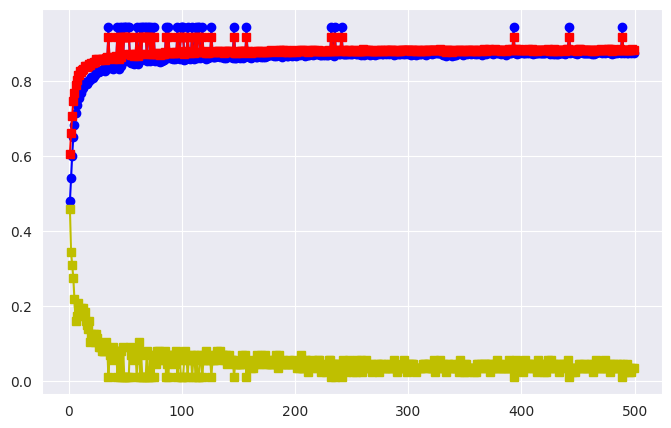

In [22]:
k_values = np.arange(1, 499 + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, metrics_df['accuracy'], marker='o', linestyle='-', label="Accuracy", color='b')
plt.plot(k_values, metrics_df['f1_weighted'], marker='s', linestyle='-', label="F1 score", color='r')
plt.plot(k_values, metrics_df['recall_class1'], marker='s', linestyle='-', label="Recall", color='y')

# Set y-axis limits to zoom in on differences
plt.ylim(min(min(metrics_df['f1_weighted']), min(metrics_df['accuracy']),metrics_df['recall_class1']) - 0.01,
         max(max(metrics_df['f1_weighted']), max(metrics_df['accuracy']),metrics_df['recall_class1']) + 0.01)

# Labels and title
plt.xlabel("Top k Features")
plt.ylabel("Score")
plt.title("F1 Score vs Accuracy for Different Top-k Features")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [24]:
metrics_df['recall_class1'][100:135]

100    0.011494
101    0.057471
102    0.080460
103    0.068966
104    0.011494
105    0.057471
106    0.057471
107    0.068966
108    0.011494
109    0.057471
110    0.068966
111    0.011494
112    0.068966
113    0.011494
114    0.011494
115    0.057471
116    0.068966
117    0.011494
118    0.057471
119    0.068966
120    0.080460
121    0.057471
122    0.057471
123    0.068966
124    0.057471
125    0.011494
126    0.057471
127    0.057471
128    0.068966
129    0.057471
130    0.080460
131    0.068966
132    0.068966
133    0.080460
134    0.068966
Name: recall_class1, dtype: float64

In [25]:
metrics_df['accuracy'][100:135]

100    0.944516
101    0.856129
102    0.865806
103    0.859355
104    0.944516
105    0.861935
106    0.859355
107    0.864516
108    0.944516
109    0.863226
110    0.858710
111    0.944516
112    0.861290
113    0.944516
114    0.944516
115    0.862581
116    0.863226
117    0.944516
118    0.863871
119    0.866452
120    0.859355
121    0.863871
122    0.861290
123    0.864516
124    0.863226
125    0.944516
126    0.865161
127    0.863871
128    0.865161
129    0.865806
130    0.867097
131    0.865806
132    0.867097
133    0.863871
134    0.865161
Name: accuracy, dtype: float64

In [26]:
# Get the top 130 features from shap_df
top_features = shap_df["feature"].head(131).tolist()
# Ensure 'RegistrationCode' is at the beginning
selected_columns = ["RegistrationCode"] + top_features

# Filter embeddings_df based on selected columns
filtered_embeddings_df = embeddings_df_baseline[selected_columns]
filtered_embeddings_df.head(5)
# Save the filtered DataFrame
filtered_embeddings_df.to_csv("filtered_patient_embeddings.csv", index=False)

In [27]:
# get the patient embeddings obtained with ClinicalBERT
embeddings_df_followup = pd.read_csv("followup_patient_embeddings.csv")
filtered_embeddings_df = embeddings_df_followup[["research_stage"] +selected_columns]
filtered_embeddings_df.to_csv("followup_filtered_patient_embeddings.csv", index=False)

### Where is all the data?
- filtered_patient_embeddings.csv, contains the embeddings obtained with ClnicalBERT filtered by SHAP value based on predictive power over 6 medical condition.
- followup_filtered_patient_embeddings.csv, filtered embedings for each stage of follow up.
- df_conditions_followup, contains information about the new conditions arising and when.
- general_info, contains the general medical information of each patient. \
Now we must obtain the CGM data and analyze it, in order to build our graphs

## CGM analysis
Let us use NMF to find a set of signature that can simplify our analysis of the CGM data.

### Upload the CGM data



In [28]:
study_ids = [10, 1001, 1002]
cgm =CGMLoader().get_data(study_ids = study_ids)
df_cgm = cgm.df

In [29]:
# Group the data by patient (RegistrationCode) and day
# Convert 'Date' to a date (no time component)
df_cgm = df_cgm.reset_index()
df_cgm['Date'] = pd.to_datetime(df_cgm['Date']).dt.date
grouped = df_cgm.groupby(['RegistrationCode', 'Date'])

# Identify groups (patient/day) with exactly 96 data points
valid_groups = [name for name, group in grouped if len(group) == 96]
# Build a list of signals (each signal is an array of 96 sorted measurements)
signals = []
for group_key in valid_groups:
    group = grouped.get_group(group_key)
    group_sorted = group.sort_values('Date')
    # Collect the measurements (assuming the column of interest is 'GlucoseValue')
    signals.append(group_sorted['GlucoseValue'].values)

# Convert the list to a matrix: each row is a daily signal with 96 measurements.
X = np.array(signals)
print("Data matrix shape:", X.shape)  # Should be (n_samples, 96)



Data matrix shape: (112744, 96)


### --- 2. Finding the Optimal Number of NMF Components ---

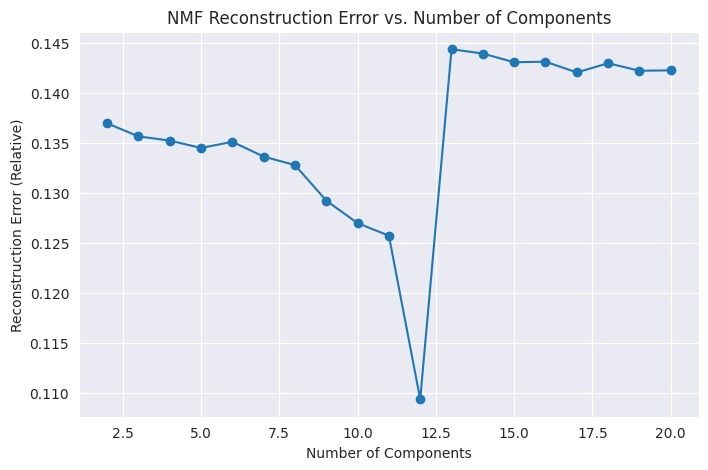

In [30]:
errors = []
components_range = range(2, 21)  # Testing from 2 to 10 components

for n_components in components_range:
    model = NMF(n_components=n_components, init='nndsvda', random_state=0, max_iter=500)
    W = model.fit_transform(X)
    H = model.components_
    reconstruction = np.dot(W, H)
    error = np.linalg.norm(X - reconstruction)/ np.linalg.norm(X)  # Frobenius norm
    errors.append(error)

# Plot reconstruction error vs. number of components
plt.figure(figsize=(8, 5))
plt.plot(list(components_range), errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (Relative)')
plt.title('NMF Reconstruction Error vs. Number of Components')
plt.show()

In [31]:
# Choose the optimal number of components (e.g., the one with the lowest error)
optimal_k = components_range[np.argmin(errors)]
print("Optimal number of components:", optimal_k)


Optimal number of components: 12


### --- 3. Perform NMF with the Optimal Number of Components ---

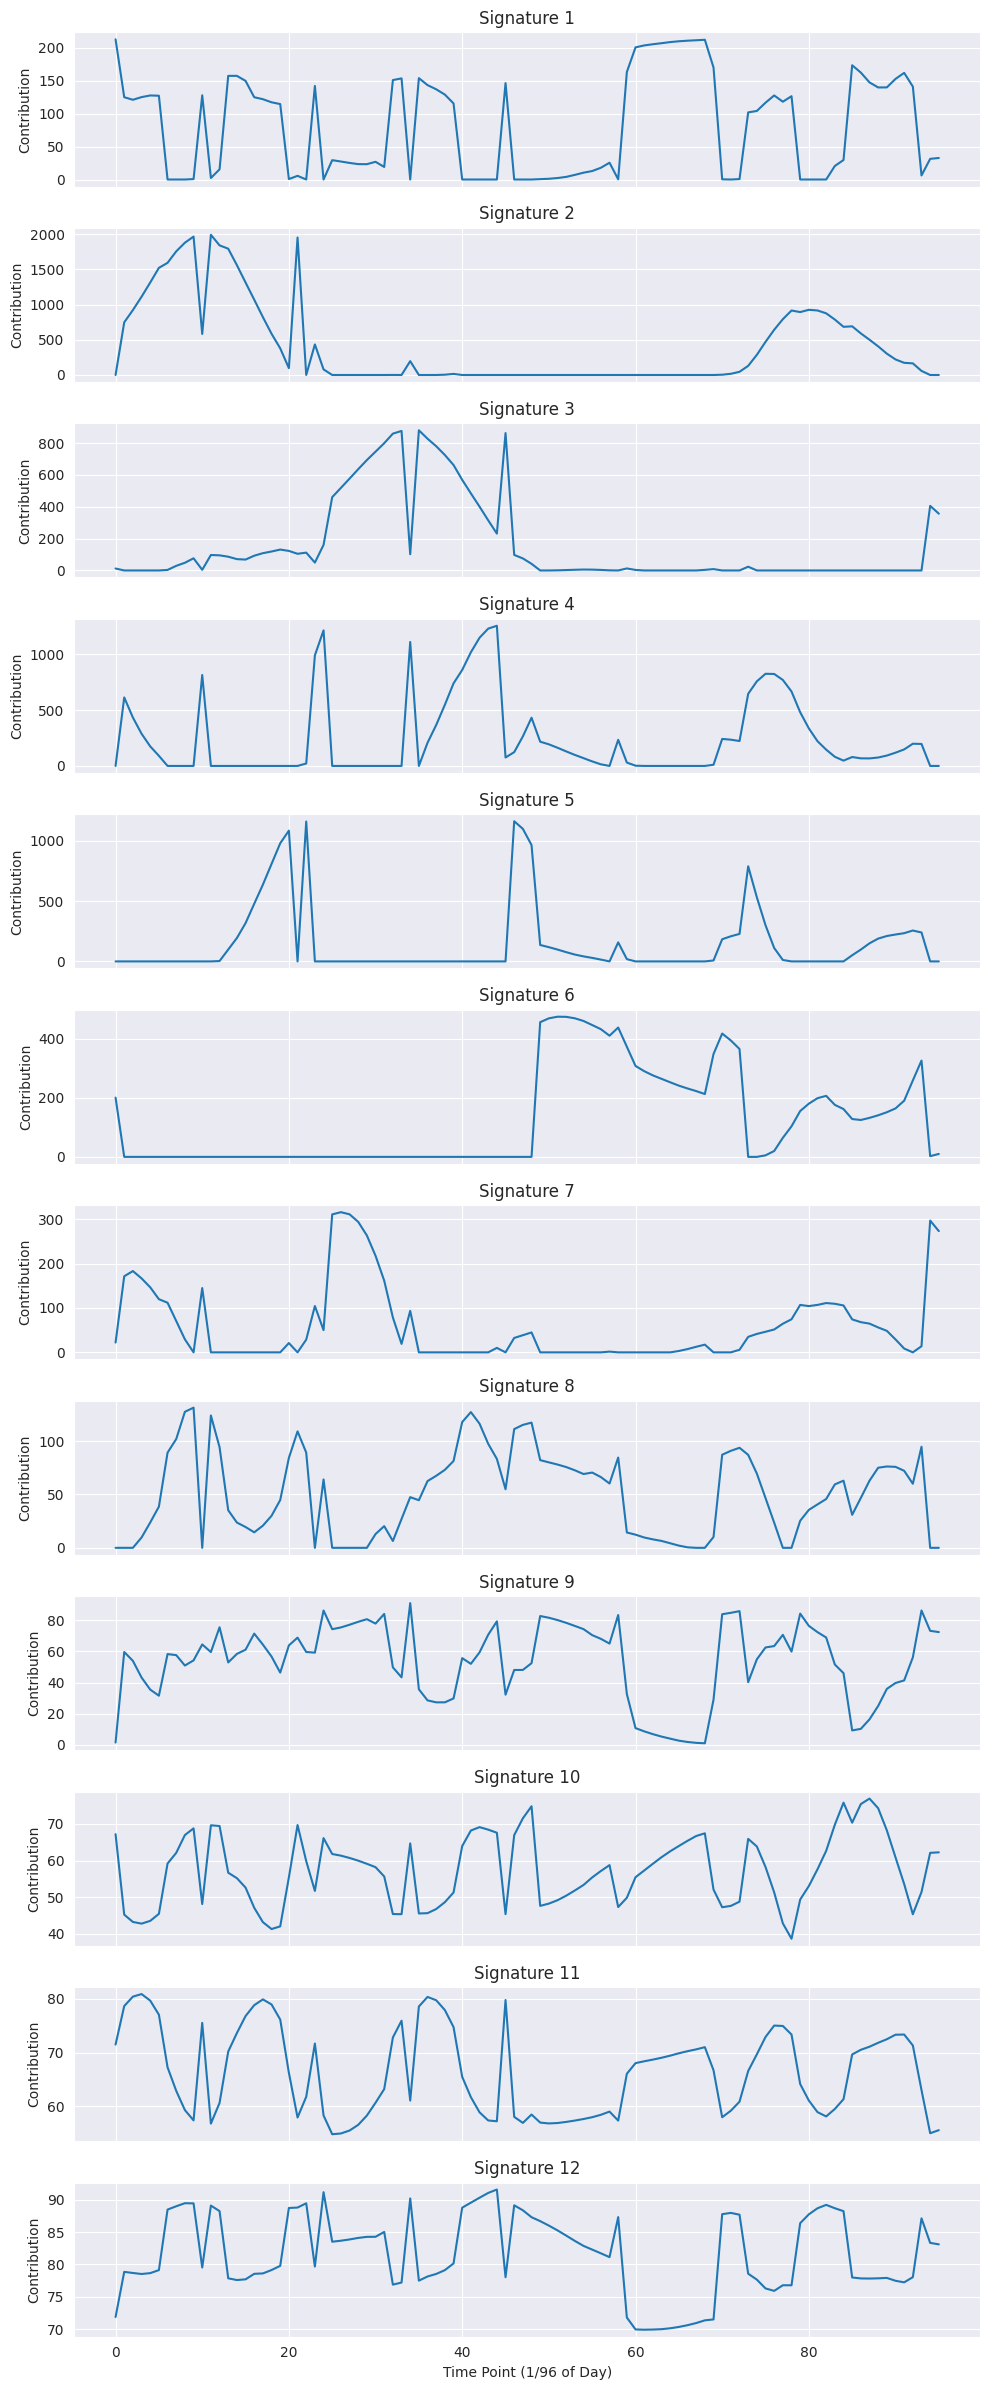

<Figure size 640x480 with 0 Axes>

In [33]:

model = NMF(n_components=optimal_k, init='nndsvda', random_state=0, max_iter=500)
W = model.fit_transform(X)  # Coefficient matrix: (n_samples x optimal_k)
H = model.components_       # Signature matrix: (optimal_k x 96)

# --- 4. Plot the Signatures ---

# Each row of H is a signature representing a pattern across 96 time points.
fig, axs = plt.subplots(optimal_k, 1, figsize=(10, 2 * optimal_k), sharex=True)

# Create a time axis corresponding to the 96 points (e.g., representing 15-minute intervals over a day)
time = np.arange(96)

for i in range(optimal_k):
    axs[i].plot(time, H[i, :], linestyle='-')  # Removed marker='o' for smooth lines
    axs[i].set_title(f'Signature {i + 1}')
    axs[i].set_ylabel('Contribution')
    axs[i].grid(True)

plt.xlabel('Time Point (1/96 of Day)')
plt.tight_layout()
plt.show()
plt.savefig('nmf_signatures.png')

In [70]:
np.save("nmf_cgm_signatures.npy", H)